# Explaining XGBoost model predictions with SHAP values

## Plain English summary

Machine learning models often do not offer an easy way to determine how they have arrived at a prediction, and have been referred to as a "black box". 

Even with our simplified model with 10 features, the model algorithm does not report how it has arrived at a prediction. We can calculate and use SHAP values tp report the average contribution a feature has on the models outcome, across all possible combination of inputs. SHAP values are calculated externally from the model. We will use them to explore what influence each feature has on the models prediction - they can either show information for an individual instance (see which feature pulls the outcome in which direction), or for the global case for the full set of instances.

SHAP values are calculated for each feature (our model has 142 features since we are using one-hot encoding for hospitals), for each instance, for each of the 5 kfolds.

On an instance level, waterfall plots clearly show the feature contribution to the models prediction. Individual instances have their own order of feature contribution. On a global level, beeswarm and scatter plots both help to explain the relationship between feature values and model prediction. 

SHAP values rank the five most influential features as: stroke type, arrival-to-scan time, stroke severity, onset time type, prior disability level.

Since we are using one-hot encoded features for the hospital, each hospital has a SHAP value of its own per instance. That means that we have a SHAP value for the hospital a patient attended, as well as for the 131 hospitals that the patient did not attend. For the hospital’s own patients, the mean SHAP values range from -1.4 to 1.3. This shows that hospitals themselves have an impact on whether the patient is likely to receive thrombolysis. This can be thought of as representing the individual hospital's thrombolysis culture.

The XGBoost model does provide a measure of feature importance. We found that there is a reasonable similarity between the feature importance and the SHAP values, but with some differences in the ranked order. Both the SHAP values and feature importance values have good consistency across the 5 k-fold splits.

## A note on SHAP values

SHAP values are usually reported as *log odds shifts* in model predictions. For a description of the relationships between probability, odds, and SHAP values (log odds shifts) see [here](../introduction/odds_prob.md).

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will receive thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

The Python library SHAP was applied to each of the 5 fitted models (one per kfold) to obtain a SHAP value for each feature, for each instance. SHAP values are in the same units as the model output, so for XGBoost this is in log odds-ratio.

A single SHAP value per feature (to compare with the feature importance value) was obtained by taking the mean of the absolute values across all instances. Then for both cases (feature importance and SHAP) take the median across the 5 kfolds.

## Aims:

* Fit XGBoost model to each of the 5 k-fold train/test splits.
* Get SHAP values for each k-fold split.
* Examine consistency of SHAP values across the 5 k-fold splits.
* Get XGBoost feature importance values for each k-fold split.
* Examine consistency of XGBoost feature importance values across the 5 k-fold splits.
* Compare SHAP values and XGBoost feature importance values.
* Using just the first k-fold, further investigate the relationship between feature values and SHAP values with:
    * Beeswarm plots
    * Waterfall plots
    * Scatter plots
    * Violin plots
    * Histograms
* Show an example of plotting SHAP values in a waterfall plot as probabilities rather than log odds-ratio.

## Observations

* There was good consistency of SHAP values and importances across 5 k-fold replications.
* There was a reasonable correlation between SHAP and feature importance values, but also some differences in the rank order of importance.
    The five most influential features as judged by SHAP were:
    * Stroke type
    * Arrival-to-scan time
    * Stroke severity (NIHSS)
    * Stroke onset time type (precise vs. estimated)
    * Disability level (Rankin) before stroke
* The five most influential features (excluding teams) as judged by importance were:
    * Stroke type
    * Use of AF Anticoagulant
    * Onset during sleep
    * Stroke onset time type (precise vs. estimated)
    * Stroke severity (NIHSS)
* Beeswarm, waterfall, and scatter plots all help elucidate the relationship between feature values and SHAP value.
* Plotting SHAP values as probabilities are more understandable than plotting as log odds-ratios, but can distort the relative importance of features overall.
* A feature with the same value in multiple instances (such as all of the patients with an infarction), the feature (stroke type) does not necessarily have the same SHAP value in all of those instances. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values).  See the set of notebooks #12 that looks at representing the SHAP values as a main effect (what is due to the feature value, the standalone effect) and as the interactions with the other features (a value per feature pairings).

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import shap

from scipy import stats
from xgboost import XGBClassifier

from os.path import exists

# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

Read in data and keep the number of key features as specified (for this notebook, that's 8 key features)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty lists
train_data_kfold, test_data_kfold = [], []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for k in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(k))
    train = train[key_features]
    train.rename(columns=dict_feature_name, inplace=True)
    train_data_kfold.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(k))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

## Get list of feature names

In [7]:
feature_names = list(train_data_kfold[0])

## Read in XGBoost model and results

In notebook 02_xgb_combined_fit_accuracy_key_features.ipynb we fit an XGBoost model for each k-fold training/test split, and got feature importance values (a value per feature, per model from each k-fold split).

Load the models.

In [8]:
# Set up lists for k-fold fits
model_kfold = []
feature_importance_kfold = []
y_pred_kfold = []
y_prob_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

# For each k-fold split
for k in range(5):
    # Get X and y
    X_train = train_data_kfold[k].drop('Thrombolysis', axis=1)
    X_test = test_data_kfold[k].drop('Thrombolysis', axis=1)
    y_train = train_data_kfold[k]['Thrombolysis']
    y_test = test_data_kfold[k]['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)
    
    # Store processed X and y
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Load models
    filename = f'./saved_models/02_{model_text}_{k}.p'
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
        model_kfold.append(model)        

    # Get and store feature importance values
    feature_names_ohe = list(X_train_kfold[0])
    feature_importances = model.feature_importances_
    df = pd.DataFrame(index=feature_names_ohe)
    df['importance'] = feature_importances
    df['rank'] = (df['importance'].rank(ascending=False).values)
    feature_importance_kfold.append(df)

    # Get and store predicted class and probability
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_prob_kfold.append(y_prob)

    # Measure accuracy for this k-fold model
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy k-fold {k+1}: {accuracy:0.3f}')

Accuracy k-fold 1: 0.848
Accuracy k-fold 2: 0.853
Accuracy k-fold 3: 0.845
Accuracy k-fold 4: 0.854
Accuracy k-fold 5: 0.848


In [9]:
# Combine y_prob_kfold into a single array
y_prob_combined = np.concatenate(y_prob_kfold)
y_prob_combined = pd.Series(y_prob_combined)
y_prob_combined.index = range(len(y_prob_combined))
y_prob_combined.to_csv(f'./predictions/03_{model_text}_y_prob_combined.csv', index=False)

## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.
A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [10]:
# Initialise empty lists
shap_values_extended_kfold = []
shap_values_kfold = []

# For each k-fold split
for k in range(5):
    # Set filename
    filename = (f'./output/'
                f'{notebook}_{model_text}_shap_values_extended_{k}.p')
    # Check if exists
    file_exists = exists(filename)
    
    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values_extended_kfold.append(shap_values_extended)
            shap_values_kfold.append(shap_values_extended.values)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test_kfold[k])
        shap_values_extended_kfold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_kfold.append(shap_values)        

        explainer_filename = (f'./output/'
                    f'{notebook}_{model_text}_shap_explainer_{k}.p')        
        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
        # Print progress
        print (f'Completed {k+1} of 5')

### Get average SHAP values for each k-fold

For each k-fold split, calculate the mean SHAP value for each feature (across all instances).
The mean is calculated in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

In [11]:
# Initialise empty lists
shap_values_mean_kfold = []

# For each k-fold split
for k in range(5):
    # Calculate mean SHAP value for each feature (across all instances)
    shap_values = shap_values_kfold[k]
    df = pd.DataFrame(index=feature_names_ohe)
    df['mean_shap'] = np.mean(shap_values, axis=0)
    df['abs_mean_shap'] = np.abs(df['mean_shap'])
    df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    df['rank'] = df['mean_abs_shap'].rank(
        ascending=False).values
    df.sort_index()
    shap_values_mean_kfold.append(df)

### Examine consistency of SHAP values across k-fold splits

A model is fitted to each k-fold split, and SHAP values are obtained for each model. This next section assesses the range of SHAP values (mean |SHAP|) for each feature across the k-fold splits.

In [12]:
# Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
df_mean_abs_shap = pd.DataFrame()

# For each k-fold split
for k in range(5):
    # mean of the absolute SHAP values for each k-fold split
    df_mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']

In [13]:
df_mean_abs_shap

,0,1,2,3,4
Arrival-to-scan time,1.235386,1.183838,1.070147,1.097156,1.004764
Infarction,2.264395,2.217960,2.135242,2.133385,2.136224
Stroke severity,1.008152,0.889078,1.022190,0.956850,0.997348
Precise onset time,0.559713,0.568196,0.509191,0.586817,0.542354
Prior disability level,0.383881,0.414714,0.405664,0.397017,0.396697
...,...,...,...,...,...
team_YPKYH1768F,0.001105,0.003267,0.000611,0.000815,0.000721
team_YQMZV4284N,0.001768,0.002489,0.002360,0.001492,0.001622
team_ZBVSO0975W,0.002655,0.005890,0.009275,0.002379,0.011138
team_ZHCLE1578P,0.004712,0.001715,0.004749,0.001117,0.003324


Create (and show) a dataframe that stores the min, median, and max SHAP values for each feature across the 5 k-fold splits

In [14]:
df_mean_abs_shap_summary = pd.DataFrame()
df_mean_abs_shap_summary['min'] = df_mean_abs_shap.min(axis=1)
df_mean_abs_shap_summary['median'] = df_mean_abs_shap.median(axis=1) 
df_mean_abs_shap_summary['max'] = df_mean_abs_shap.max(axis=1)
df_mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [15]:
df_mean_abs_shap_summary

,min,median,max
Infarction,2.133385,2.136224,2.264395
Arrival-to-scan time,1.004764,1.097156,1.235386
Stroke severity,0.889078,0.997348,1.022190
Precise onset time,0.509191,0.559713,0.586817
Prior disability level,0.383881,0.397017,0.414714
...,...,...,...
team_WSNTP4114A,0.000239,0.000409,0.000927
team_LLPWF6176Z,0.000320,0.000345,0.001314
team_CYVHC2532V,0.000000,0.000319,0.001531
team_JXJYG0100P,0.000000,0.000131,0.000247


Identify the 10 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values)

In [16]:
top_10_shap = list(df_mean_abs_shap_summary.head(10).index)

Create a violin plot for these 10 features with the highest SHAP values.

A violin plot shows the distribution of the SHAP values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

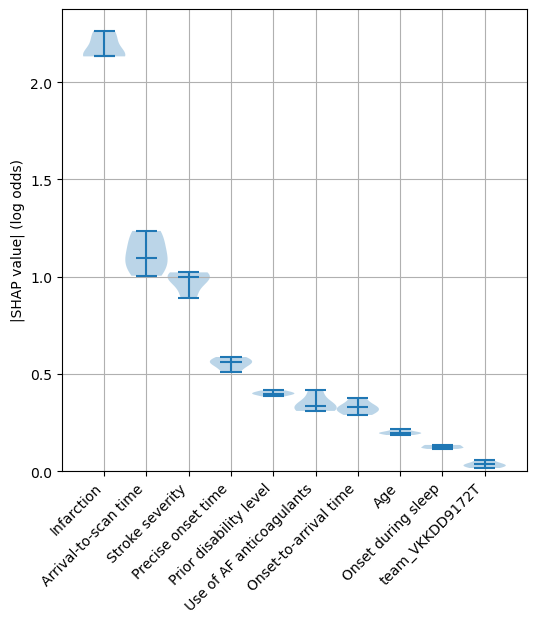

In [17]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_mean_abs_shap.loc[top_10_shap].T,
               showmedians=True,
               widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('|SHAP value| (log odds)')
plt.savefig(f'output/{notebook}_{model_text}_shap_violin.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Examine the consitency of feature importances across k-fold splits

XGBoost algorithm provides a metrc per feature called "feature importance".

A model is fitted to each k-fold split, and feature importance values are obtained for each model. This next section assesses the range of feature importance values for each feature across the k-fold splits.

In [18]:
# Initialise DataFrame (stores feature importance values for each kfold)
df_feature_importance = pd.DataFrame()

# For each k-fold
for k in range(5):
    # feature importance value for each k-fold split
    df_feature_importance[f'{k}'] = feature_importance_kfold[k]['importance']

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [19]:
df_feature_importance_summary = pd.DataFrame()
df_feature_importance_summary['min'] = df_feature_importance.min(axis=1)
df_feature_importance_summary['median'] = df_feature_importance.median(axis=1) 
df_feature_importance_summary['max'] = df_feature_importance.max(axis=1)
df_feature_importance_summary.sort_values('median', inplace=True, 
                                          ascending=False)

In [20]:
df_feature_importance_summary

,min,median,max
Infarction,0.329892,0.342228,0.344690
Use of AF anticoagulants,0.040316,0.043855,0.060380
Onset during sleep,0.030445,0.034854,0.036365
Precise onset time,0.024713,0.028647,0.037972
Stroke severity,0.012850,0.013282,0.013868
...,...,...,...
team_JXJYG0100P,0.000000,0.001177,0.002705
team_UMYTD3128E,0.000995,0.001133,0.002014
team_HONZP0443O,0.000000,0.000870,0.001818
team_FWHZZ0143J,0.000321,0.000715,0.002012


Identify the 10 features with the highest feature importance values.

In [21]:
top_10_importances = list(df_feature_importance_summary.head(10).index)

Create a violin plot for these 10 features with the highest feature importance values.

A violin plot shows the distribution of the feature importance values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

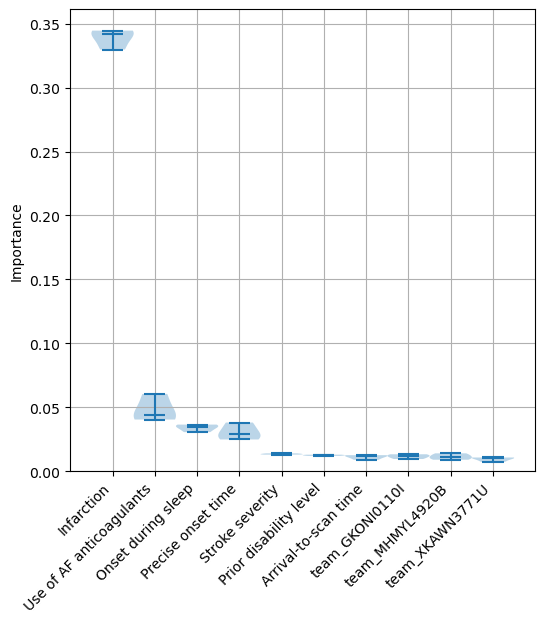

In [22]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_feature_importance_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig(f'output/{notebook}_{model_text}_importance_violin.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values

In [23]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['SHAP (feature name)'] = \
                            df_mean_abs_shap_summary.index
df_compare_shap_importance['SHAP (median value)']  = \
                            df_mean_abs_shap_summary['median'].values
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance_summary.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance_summary['median'].values
df_compare_shap_importance.head(10)

,SHAP (feature name),SHAP (median value),Importance (feature name),Importance (median value)
0,Infarction,2.136224,Infarction,0.342228
1,Arrival-to-scan time,1.097156,Use of AF anticoagulants,0.043855
2,Stroke severity,0.997348,Onset during sleep,0.034854
3,Precise onset time,0.559713,Precise onset time,0.028647
4,Prior disability level,0.397017,Stroke severity,0.013282
5,Use of AF anticoagulants,0.336457,Prior disability level,0.012378
6,Onset-to-arrival time,0.328596,Arrival-to-scan time,0.011840
7,Age,0.197168,team_GKONI0110I,0.011717
8,Onset during sleep,0.121804,team_MHMYL4920B,0.011032
9,team_VKKDD9172T,0.034483,team_XKAWN3771U,0.010357


Plot all of the features, showing feature importance vs SHAP values.

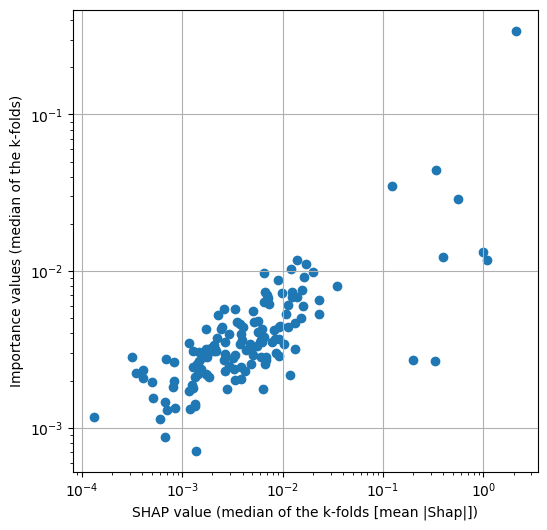

In [24]:
df_shap_importance = pd.DataFrame()
df_shap_importance['Shap'] = df_mean_abs_shap_summary['median']
df_shap_importance = df_shap_importance.merge(
    df_feature_importance_summary['median'], left_index=True, right_index=True)
df_shap_importance.rename(columns={'median':'Importance'}, inplace=True)
df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(df_shap_importance['Shap'],
            df_shap_importance['Importance'])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
ax1.set_ylabel('Importance values (median of the k-folds)')
ax1.grid()
plt.savefig(f'output/{notebook}_{model_text}_shap_importance_correlation.jpg', 
            dpi=300)
plt.show()

## SHAP values in more detail, using the first k-fold

Having established that SHAP values have good consistency across k-fold splits, here we show more detail on SHAP using the first k-fold split.

First, get the key values from the first k fold split

In [25]:
k = 0
model = model_kfold[k]
shap_values = shap_values_kfold[k]
shap_values_extended = shap_values_extended_kfold[k]
importances = feature_importance_kfold[k]
y_pred = y_pred_kfold[k]
y_prob = y_prob_kfold[k]
X_train = X_train_kfold[k]
X_test = X_test_kfold[k]
y_train = y_train_kfold[k]
y_test = y_test_kfold[k]

### View the global case: Beeswarm plot

A Beeswarm plot shows data for all instances. 

The feature value for each point is shown by the colour, and its position indicates the SHAP value for that instance.

Beeswarm plots are used to get a global picture of how the feature value interacts with it's SHAP value.

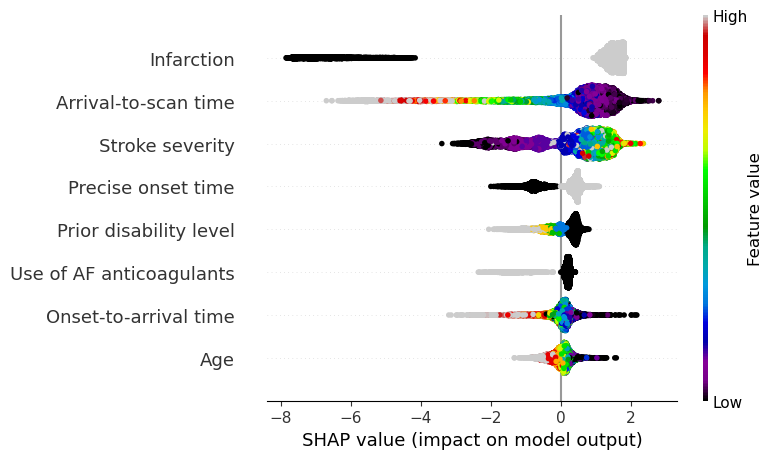

In [26]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=feature_names_ohe,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig(f'output/{notebook}_{model_text}_beeswarm.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### View the individual case: Waterfall plots 
(showing log odds ratio)

Waterfall plots are ways of plotting the influence of features for individual cases. Here we show them for two instances: one with low, and one with high probability of receiving thrombolysis.

For both cases, the prediction starts at the base SHAP value (the expected value for each instance, without knowing any information of their features). This is at the bottom of the graph. Each bar shows the contribution to the prediction due to an individual feature value. Until all have added their contribution at the top of the graph. The final prediction.

Note: A decision plot is an alternative method of showing the same data. For further information see here: 
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html

In [27]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9
location_low_probability = np.where(y_prob <0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]

A waterfall plot example with low probability of receiving thrombolysis (showing log odds ratio).

Usng the waterfall function:
* y_reverse==True puts expected value at top and predicted value at bottom of plot
* rank_absolute==False determines the order of the features using their raw value
* raw_ascending==False from the expected value put the features in order of: most positive to smallest positive, then least negative to most negative

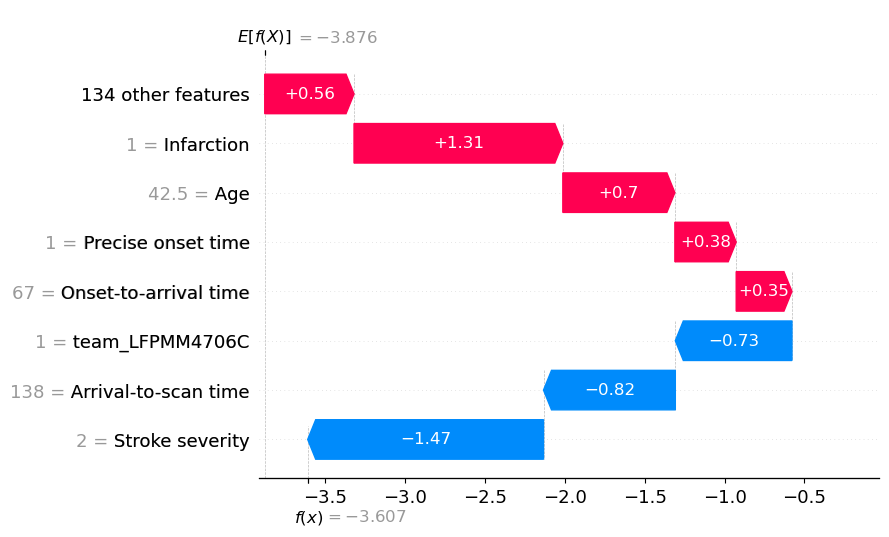

In [28]:
fig = waterfall.waterfall(shap_values_extended[location_low_probability],
                          show=False, max_display=8, y_reverse=True, 
                          rank_absolute=False, raw_ascending=False)

plt.savefig(f'output/{notebook}_{model_text}_waterfall_logodds_low.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

An waterfall plot example with high probability of receiving thrombolysis (showing log odds ratio).

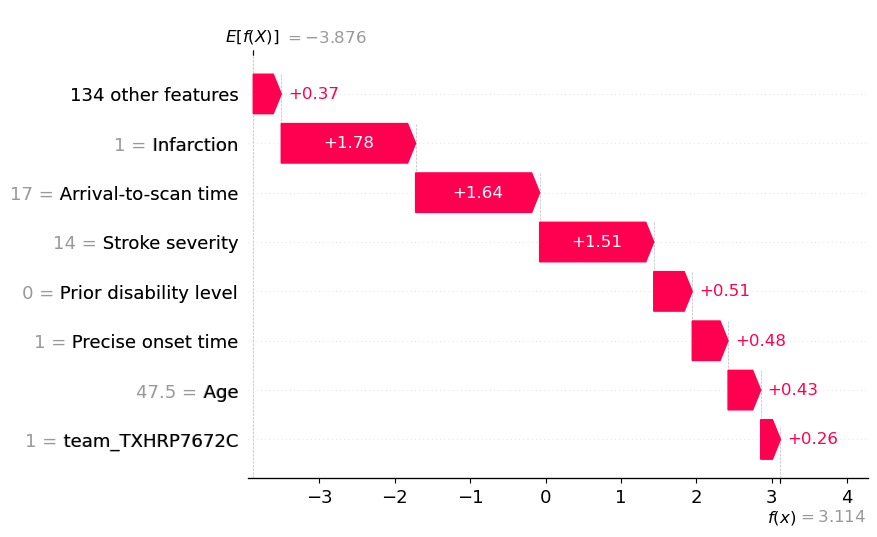

In [29]:
fig = waterfall.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8, y_reverse=True, 
                          rank_absolute=False, raw_ascending=False)
plt.savefig(f'output/{notebook}_{model_text}_waterfall_logodds_high.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### View the individual case: Waterfall plots (showing probabilities)

Though SHAP values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot the same waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features somewhat - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

Here we show the same two instances, with probability rather than log odds ratio.

In [30]:
# Set filename
filename = (f'./output/{notebook}_{model_text}_'
            f'shap_values_probability_extended_{k}.p')
# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_probability_extended = pickle.load(filehandler)
        shap_values_probability = shap_values_probability_extended.values
else:
    # Calculate SHAP values
    # Set up explainer using typical feature values from training set
    explainer_probability = shap.TreeExplainer(model, X_train, 
                                               model_output='probability')
    
    # Get Shapley values along with base and features
    shap_values_probability_extended = explainer_probability(X_test)
    # Shap values exist for each classification in a Tree
    shap_values_probability = shap_values_probability_extended.values

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_probability_extended, filehandler)

A waterfall plot example with low probability of receiving thrombolysis (showing probabilites).

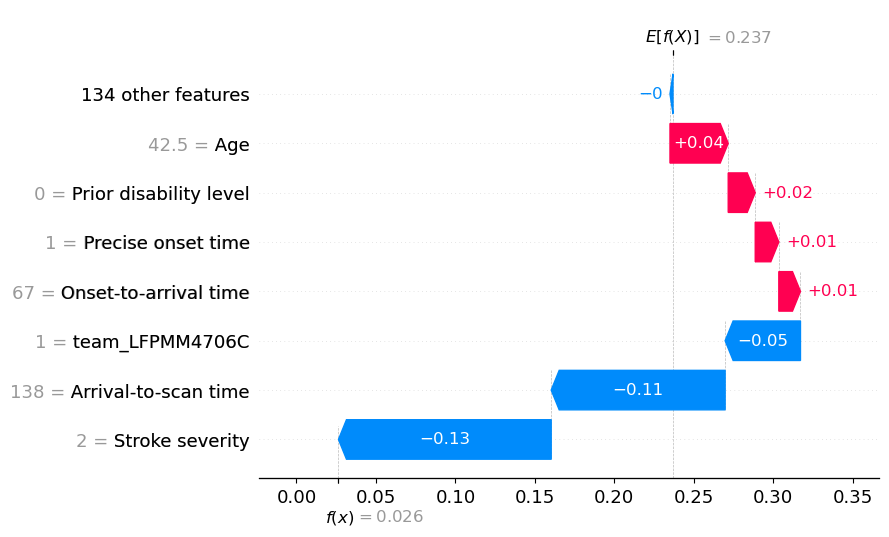

In [31]:
fig = waterfall.waterfall(
                shap_values_probability_extended[location_low_probability],
                show=False, max_display=8, y_reverse=True, rank_absolute=False, 
                raw_ascending=False)
plt.savefig(f'output/{notebook}_{model_text}_waterfall_probability_low.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

An waterfall plot example with high probability of receiving thrombolysis (showing probabilities).

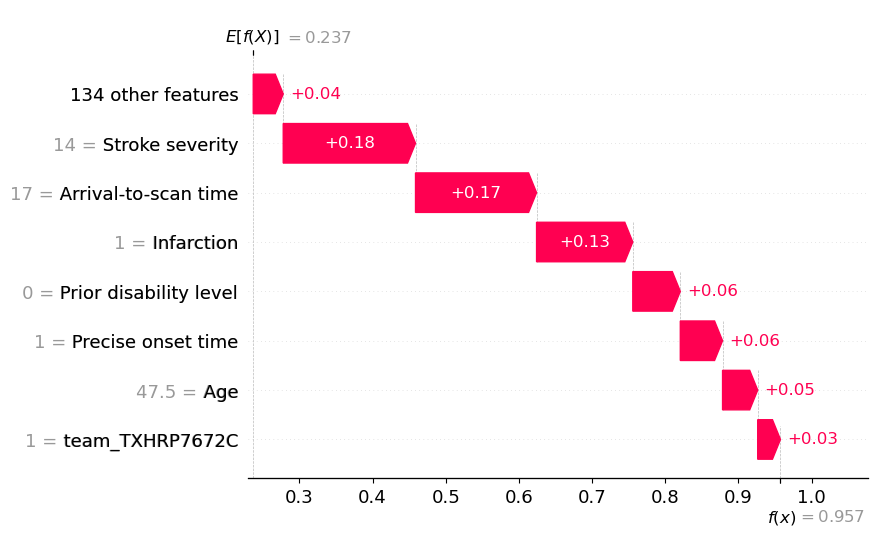

In [32]:
fig = waterfall.waterfall(
                shap_values_probability_extended[location_high_probability],
                show=False, max_display=8, y_reverse=True, rank_absolute=False,
                raw_ascending=False)
plt.savefig(f'output/{notebook}_{model_text}_waterfall_probability_high.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Show the relationship between feature value and SHAP value for the top 6 influential features
(as SHAP plots scatter)

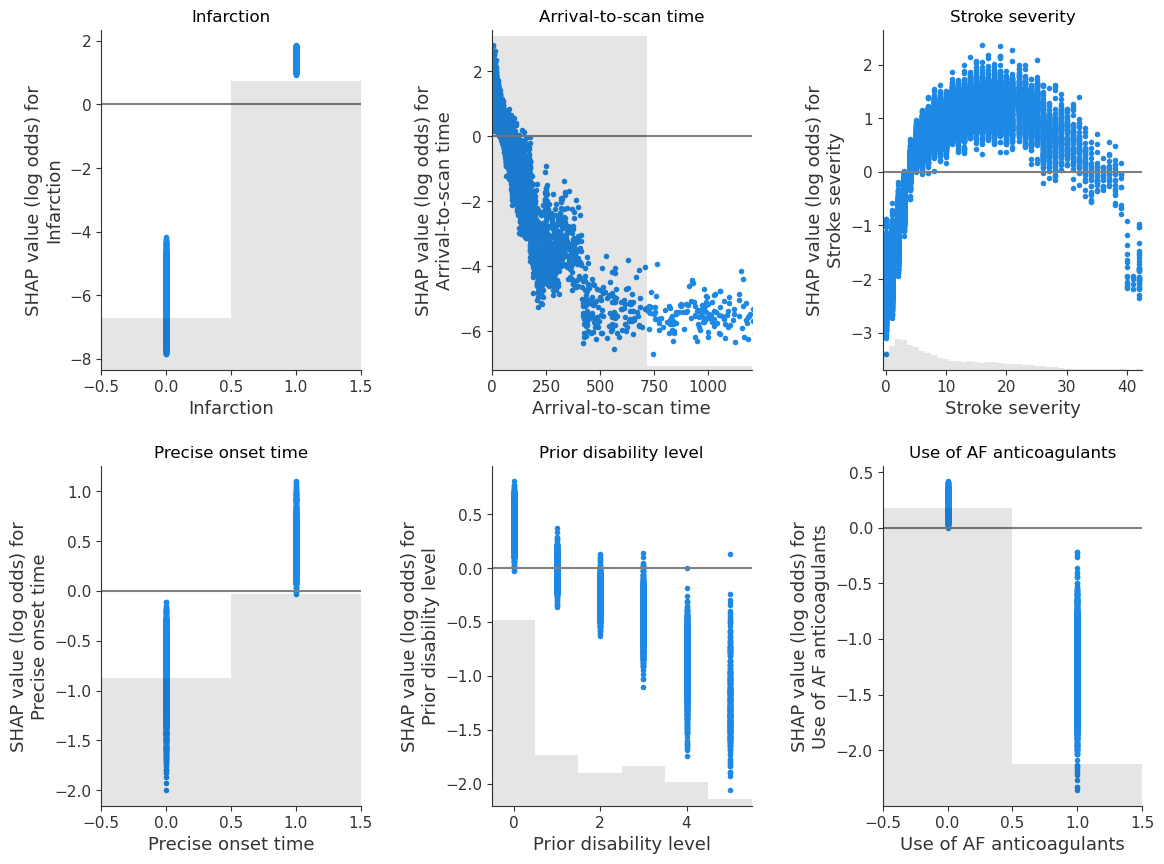

In [33]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
for n, feat in enumerate(feat_to_show):    
    ax = fig.add_subplot(2,3,n+1)
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
    # Censor arrival to scan to 1200 minutes
    if feat == 'Arrival-to-scan time':
        ax.set_xlim(0,1200)
    
plt.tight_layout(pad=2)

fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_scatter.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

### Show the relationship between feature value and SHAP value for the top 6 influential features
(as violin plots)

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [34]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

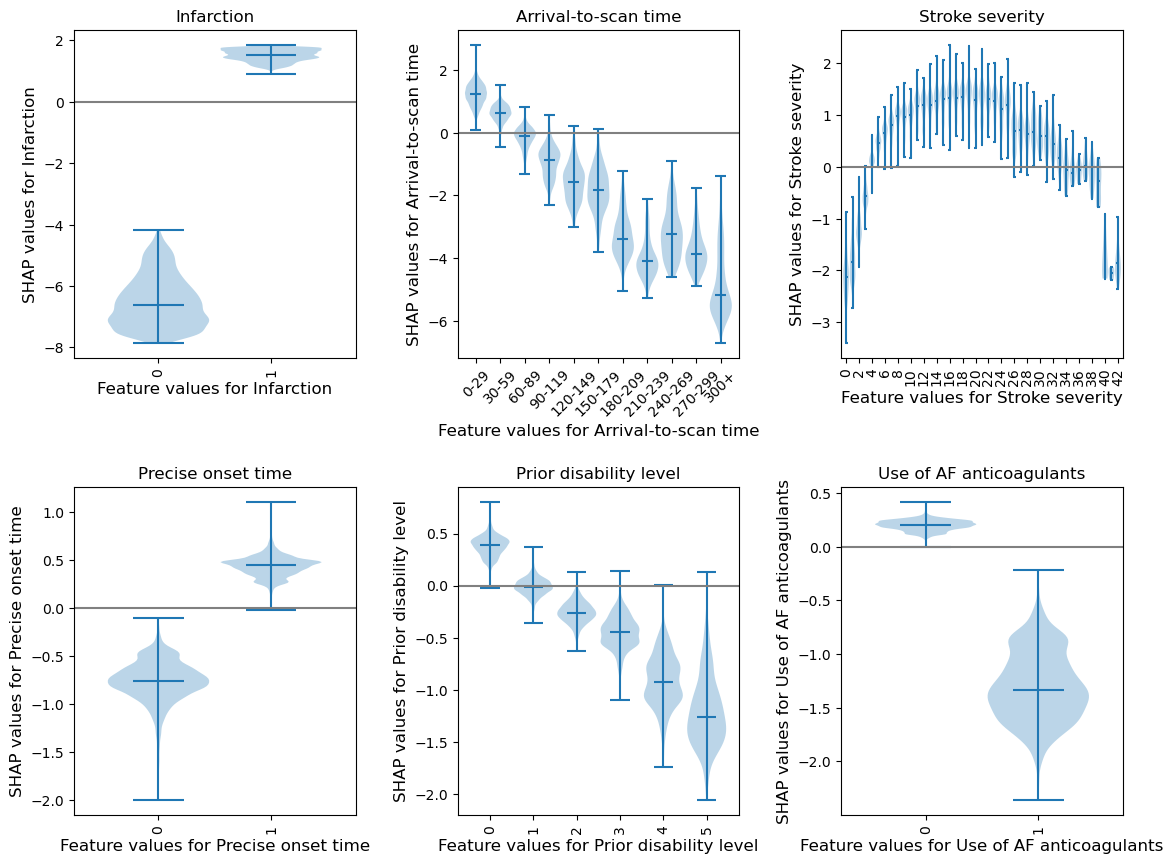

In [35]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(feat_to_show):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # create violin plot
    ax = fig.add_subplot(2,3,n+1)
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2]) 
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_violin.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

### Compare SHAP values for the hospital one-hot encoded features

The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (using only the first k-fold test set, and take the mean of the SHAP values for the instances for each hospital's own patients).

In [36]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
test_stroke_team = test_data_kfold[0]['Stroke team']
stroke_teams = list(np.unique(test_stroke_team))
stroke_teams.sort()
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = test_stroke_team == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = test_data_kfold[0][mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)

feature_data_with_shap.to_csv(
   f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
    index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = stroke_teams
hospital_data["shap_mean"] = stroke_team_mean_shap
hospital_data.to_csv(
    f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital_0fold.csv', 
    index=False)

In [37]:
hospital_data

,stroke_team,shap_mean
0,AGNOF1041H,-0.029137
1,AKCGO9726K,0.535615
2,AOBTM3098N,-0.277465
3,APXEE8191H,-0.104798
4,ATDID5461S,0.232464
...,...,...
127,YPKYH1768F,-0.234150
128,YQMZV4284N,0.327757
129,ZBVSO0975W,-0.541979
130,ZHCLE1578P,0.108360


Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients (using only the first k-fold test set)

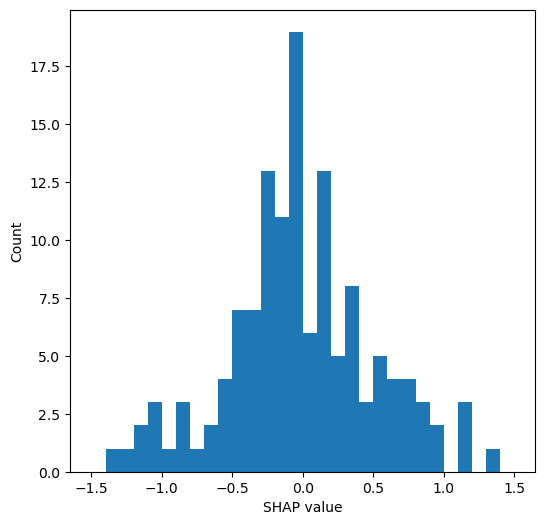

In [38]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.51, 0.1))
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [39]:
mean_shap = np.mean(stroke_team_mean_shap)
std_shap = np.std(stroke_team_mean_shap)
print(f'Mean hospital SHAP: {mean_shap:0.3f}')
print(f'Mean hospital SHAP: {std_shap:0.3f}')

Mean hospital SHAP: -0.017
Mean hospital SHAP: 0.521
